##### Copyright 2019 The TensorFlow Authors.

In [2]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Clasificación de imágenes de perros vs gatos sin aumento de imagen

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l05c01_dogs_vs_cats_without_augmentation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l05c01_dogs_vs_cats_without_augmentation.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

En este tutorial, discutiremos cómo clasificar imágenes en imágenes de gatos o imágenes de perros. Construiremos un clasificador de imágenes usando el modelo `tf.keras.Sequential` y cargaremos  los datos usando `tf.keras.preprocessing.image.ImageDataGenerator`.

## Conceptos específicos que se tratarán: 
En el proceso, construiremos experiencia práctica y desarrollaremos la intuición en torno a los siguientes conceptos 
* Construir _data input pipelines_  usando la clase `tf.keras.preprocessing.image.ImageDataGenerator` — ¿Cómo podemos trabajar eficientemente con datos en el disco para interactuar con nuestro modelo? 
* _Overfitting_ - ¿Qué es, cómo identificarlo?
<hr>



**Antes de que empieces** 

Antes de ejecutar el código en este cuaderno, restablezca el tiempo de ejecución yendo a **Runtime -> Reset all runtimes** en el menú de arriba. Si ha estado trabajando en varios notebooks, esto lo ayudará a evitar alcanzar los límites de memoria de Colab.


# Importando paquetes

Comencemos importando los paquetes requeridos: 
* os — para leer archivos y estructura de directorios 
* numpy: para algunas matemáticas de matriz fuera de TensorFlow 
* matplotlib.pyplot: para trazar el gráfico y mostrar imágenes en nuestros datos de entrenamiento y validación

In [1]:
import tensorflow as tf

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np

In [5]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Carga de datos

Para construir nuestro clasificador de imágenes, comenzamos descargando el conjunto de datos. El conjunto de datos que estamos usando es una versión filtrada del conjunto de datos <a href="https://www.kaggle.com/c/dogs-vs-cats/data" target="_blank">Dogs vs. Cats</a> de Kaggle (por último, este conjunto de datos lo proporciona Microsoft Research).

En Colabs anteriores, usamos <a href="https://www.tensorflow.org/datasets" target="_blank">TensorFlow Datasets</a>, que es una forma muy fácil y conveniente de usar Datasets. Sin embargo, en este Colab, utilizaremos la clase `tf.keras.preprocessing.image.ImageDataGenerator` que leerá los datos del disco. Por lo tanto, debemos descargar directamente *Dogs vs. Cats* desde una URL y descomprimirlo en el sistema de archivos de Colab.

In [6]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

68616192/68606236 [==============================] - 1s 0us/step


El conjunto de datos que hemos descargado tiene la siguiente estructura de directorios.

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ...]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ...]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

Podemos listar los directorios con el siguiente comando de terminal:

In [7]:
zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print

/root/.keras/datasets
/root/.keras/datasets/cats_and_dogs_filtered
/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/train/cats
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs
/root/.keras/datasets/cats_and_dogs_filtered/validation
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs


Ahora asignaremos variables con la ruta de archivo adecuada para los conjuntos de entrenamiento y validación.

In [8]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')  # directorio con nuestras fotos de gatos de entrenamiento
train_dogs_dir = os.path.join(train_dir, 'dogs')  #directorio con nuestras fotos de perros de entrenamiento
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directorio con nuestras fotos de gatos de validación
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directorio con nuestras fotos de perros de validación

### Entendiendo nuestros datos

Veamos cuántas imágenes de gatos y perros tenemos en nuestro directorio de entrenamiento y validación

In [9]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [10]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


# Configuración de parámetros del modelo

Para mayor comodidad, configuraremos variables que se utilizarán más adelante mientras procesamos previamente nuestro conjunto de datos y entrenamos nuestra red.

In [11]:
BATCH_SIZE = 100  # Número de ejemplos de entrenamiento a procesar antes de actualizar las variables de nuestros modelos
IMG_SHAPE  = 150  # Nuestros datos de entrenamiento consisten en imágenes con un ancho de 150 píxeles y una altura de 150 píxeles

# Preparación de datos

Las imágenes deben formatearse en tensores de punto flotante preprocesados ​​adecuadamente antes de introducirse en la red. Los pasos involucrados en la preparación de estas imágenes son:

1. Leer imágenes del disco 
2. Decodifique el contenido de estas imágenes y conviértalo al formato de cuadrícula adecuado según su contenido RGB 
3. Conviértelos en tensores de punto flotante 
4. Vuelva a escalar los tensores de valores entre 0 y 255 a valores entre 0 y 1, ya que las redes neuronales prefieren trabajar con valores de entrada pequeños.

Afortunadamente, todas estas tareas se pueden realizar utilizando la clase **tf.keras.preprocessing.image.ImageDataGenerator**. Podemos configurar esto en un par de líneas de código.

In [12]:
train_image_generator      = ImageDataGenerator(rescale=1./255)  # Generador de nuestro conjunto de entrenamiento
validation_image_generator = ImageDataGenerator(rescale=1./255)  # Generador de nuestro conjunto de validación

Después de definir nuestros generadores para las imágenes de entrenamiento y validación, el método **flow_from_directory** cargará imágenes desde el disco, aplicará el cambio de escala y las cambiará de tamaño usando una sola línea de código.

In [13]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                           class_mode='binary')

Found 2000 images belonging to 2 classes.


In [14]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                              class_mode='binary')

Found 1000 images belonging to 2 classes.


### Visualización de imágenes de entrenamiento

Podemos visualizar nuestras imágenes de entrenamiento obteniendo un lote de imágenes del generador de entrenamiento y luego trazando algunas de ellas usando `matplotlib`.

In [15]:
sample_training_images, _ = next(train_data_gen) 

La función `next` devuelve un lote del conjunto de datos. Un lote es una tupla de (*muchas imágenes*, *muchas etiquetas*). Por ahora, descartamos las etiquetas porque solo queremos ver las imágenes.

In [16]:
#Esta función trazará imágenes en forma de cuadrícula con 1 fila y 5 columnas donde las imágenes se colocan en cada columna.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

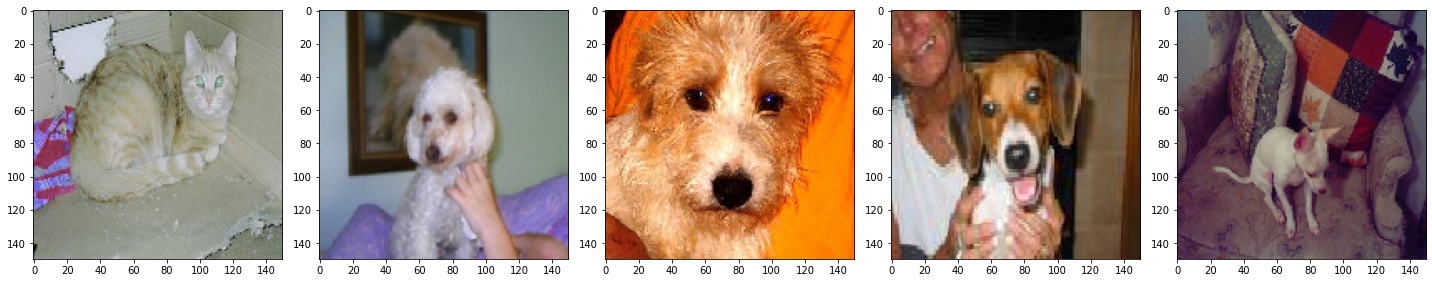

In [17]:
plotImages(sample_training_images[:5])  # Plot images 0-4

# Creación de modelos

## Definiendo el modelo
El modelo consta de cuatro bloques de convolución con una capa maxpooling en cada uno de ellos. Luego tenemos una capa totalmente conectada con 512 unidades, con una función de activación `relu`. El modelo generará probabilidades de clase para dos clases, perros y gatos, usando `softmax`.

In [18]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

Como de costumbre, utilizaremos el optimizador `adam`. Dado que generamos una categorización softmax, usaremos `sparse_categorical_crossentropy` como la función de pérdida. También nos gustaría observar la precisión del entrenamiento y la validación en cada época a medida que entrenamos nuestra red, por lo que estamos pasando el argumento de las métricas "metrics".

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Resumen del Modelo

Veamos todas las capas de nuestra red usando el método **summary**.

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

### Entrenamiento del modelo

Es hora de que entrenemos a nuestra red. 

Dado que nuestros lotes provienen de un generador (`ImageDataGenerator`), usaremos `fit_generator` en lugar de `fit`.

In [21]:
EPOCHS = 100
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/100
20/20 [==============================] - 23s 532ms/step - loss: 0.7183 - accuracy: 0.4940 - val_loss: 0.6913 - val_accuracy: 0.5000
Epoch 2/100
20/20 [==============================] - 10s 517ms/step - loss: 0.6890 - accuracy: 0.5405 - val_loss: 0.6804 - val_accuracy: 0.5080
Epoch 3/100
20/20 [==============================] - 10s 516ms/step - loss: 0.6721 - accuracy: 0.5950 - val_loss: 0.6781 - val_accuracy: 0.5580
Epoch 4/100
20/20 [==============================] - 10s 510ms/step - loss: 0.6508 - accuracy: 0.6095 - val_loss: 0.6361 - val_accuracy: 0.6460
Epoch 5/100
20/20 [==============================] - 10s 502ms/step - loss: 0.6022 - accuracy: 0.6735 - val_loss: 0.6109 - val_accuracy: 0.6690
Epoch 6/100
20/20 [==============================] - 10s 508ms/step - loss: 0.5775 - accuracy: 0.6970 - val_loss: 0.6036 - val_accuracy: 0.6870
Epoch 7/100
20/20 [==============================] - 10s 505ms/step - loss: 0.5533 - accuracy: 0.7190 - val_loss: 0.5771 - val_accuracy:

### Visualización de resultados del entrenamiento.

Ahora vamos a visualizar los resultados que obtenemos después de entrenar nuestra red.

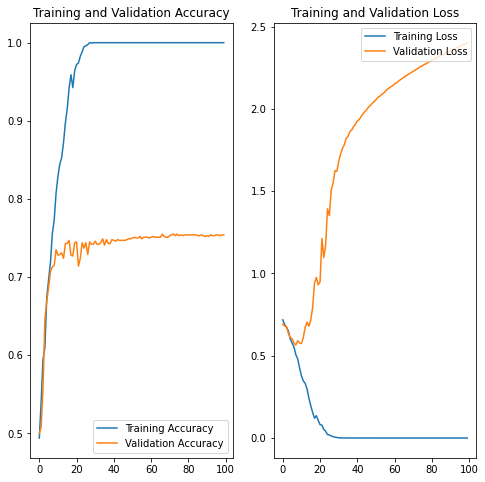

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()

Como podemos ver en los gráficos, la precisión del entrenamiento y la precisión de la validación están desfasadas por un amplio margen y nuestro modelo ha logrado solo alrededor del **70 %** de precisión en el conjunto de validación (dependiendo de la cantidad de épocas para las que entrenó).

Esta es una clara indicación de sobreajuste. Una vez que las curvas de entrenamiento y validación comienzan a divergir, nuestro modelo ha comenzado a memorizar los datos de entrenamiento y no puede funcionar bien con los datos de validación